In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [2]:
df_train = pd.read_csv('Stocks\GOOG.csv')
df_test = pd.read_csv('Stocks\TestAnomaly.csv')

## Quick look at data

In [3]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


**We will deal with the closing price for each day.**

In [4]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df_train = df_train[['Date', 'Close']]
df_test = df_test[['Date', 'Close']]

**Data Time Period**

In [5]:
df_train['Date'].min(), df_train['Date'].max()

('2019-04-22', '2024-04-19')

In [6]:
df_test['Date'].min(), df_test['Date'].max()

('4/20/2024', '9/9/2024')

In [7]:
print(df_test[df_test['Close'] > 300])


          Date       Close
15    5/5/2024  303.404999
16    5/6/2024  400.404999
17    5/7/2024  300.555000
41   5/31/2024  300.639999
42    6/1/2024  350.320719
48    6/7/2024  400.639999
65   6/24/2024  500.404999
66   6/25/2024  600.330002
67   6/26/2024  300.639999
91   7/20/2024  450.639999
92   7/21/2024  490.320719
98   7/27/2024  600.639999
115  8/13/2024  500.000000
117  8/15/2024  550.000000
141   9/8/2024  600.000000
148  9/15/2024  450.000000


## Visualize the data

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train['Date'], y=df_train['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test['Date'], y=df_test['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

## Data Preprocessing

#### 1. Train - test split

In [10]:
# train = df.loc[df['Date'] <= '2023-12-24']
# test = df.loc[df['Date'] > '2023-12-24']
df_train.shape, df_test.shape

((1259, 2), (150, 2))

#### 2. Data Scaling

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(df_train['Close']).reshape(-1,1))

df_train['Scaled_Close'] = scaler.transform(np.array(df_train['Close']).reshape(-1,1))
df_test['Scaled_Close'] = scaler.transform(np.array(df_test['Close']).reshape(-1,1))

In [12]:
df_train.head()

,Date,Close,Scaled_Close
0,2019-04-22,62.442001,-1.376841
1,2019-04-23,63.227501,-1.350872
2,2019-04-24,62.799999,-1.365006
3,2019-04-25,63.172501,-1.352690
4,2019-04-26,63.609001,-1.338259


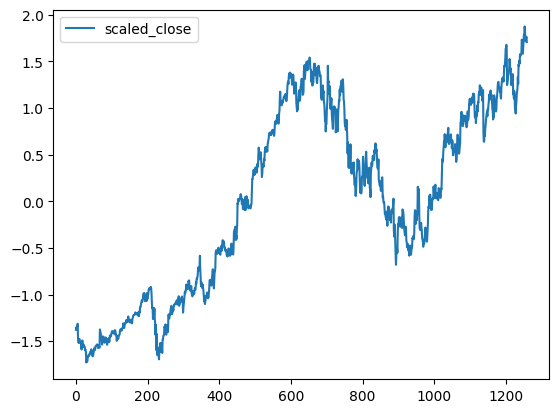

In [13]:
# Visualize scaled data
plt.plot(df_train['Scaled_Close'], label = 'scaled_close')
plt.legend()
plt.show()

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 2 as we want our network to have memory of last 2 days.

In [14]:
TIME_STEPS=2

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(df_train[['Scaled_Close']], df_train['Scaled_Close'])
X_test, y_test = create_sequences(df_test[['Scaled_Close']], df_test['Scaled_Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1257, 2, 1)
Testing input shape:  (148, 2, 1)


In [15]:
print(X_train.shape)
print(y_train.shape)

(1257, 2, 1)
(1257,)


In [16]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [17]:
# model = Sequential()
# model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(rate=0.2))
# model.add(RepeatVector(X_train.shape[1]))
# model.add(LSTM(128, activation = 'tanh', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(X_train.shape[2])))
# model.compile(optimizer='adam', loss="mae")
# model.summary()

In [18]:
# Encoder 
encoder = Sequential()
encoder.add(LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
encoder.add(Dropout(rate=0.1))
encoder.add(RepeatVector(X_train.shape[1]))
# Decoder 
decoder = Sequential() 
decoder.add(LSTM(32, activation='relu', return_sequences=True))
decoder.add(Dropout(rate=0.1))
decoder.add(TimeDistributed(Dense(X_train.shape[2])))

# Autoencoder
model = Sequential([encoder, decoder])
model.compile(loss='mae', optimizer='adam')

e:\AIO\AnamolyDetection\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



## Train Model

In [19]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')],
                    shuffle=False)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.1229 - val_loss: 0.9827
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0545 - val_loss: 0.9191
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9212 - val_loss: 0.7402
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5340 - val_loss: 0.4008
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5053 - val_loss: 0.4587
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4291 - val_loss: 0.3845
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3944 - val_loss: 0.4003
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3738 - val_loss: 0.3639
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3368 - val_loss: 0.3553
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2825 - val_loss: 0.3289
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2276 - val_loss: 0.3166
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

#### Plot Training - Validation loss

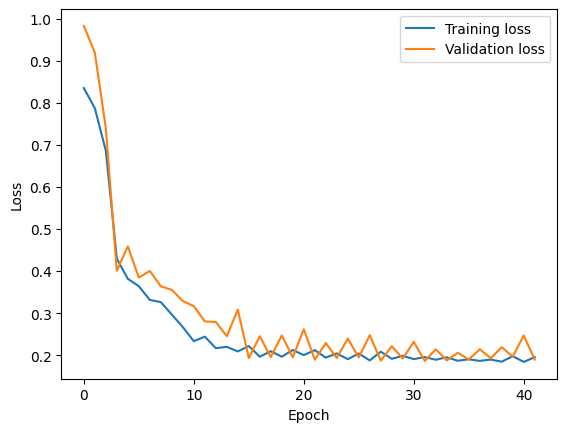

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Reconstruction error threshold: 0.3313431485102235


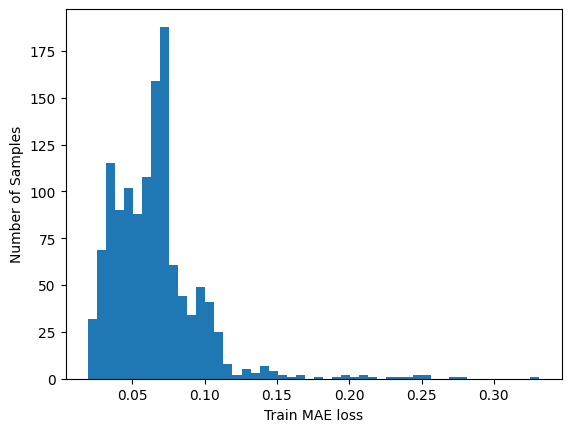

In [21]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)
#threshold = threshold - 0.05*threshold

print('Reconstruction error threshold:',threshold)

## Predict Anomalies on test data using threshold

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Text(0, 0.5, 'Number of samples')

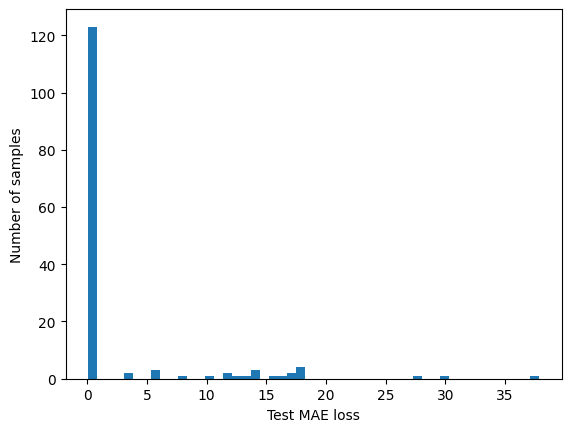

In [22]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [23]:
anomaly_df = pd.DataFrame(df_test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [24]:
anomaly_df

,Date,Close,Scaled_Close,loss,threshold,anomaly
2,4/22/2024,151.149994,1.555906,0.166794,0.331343,False
3,4/23/2024,151.699997,1.574089,0.127747,0.331343,False
4,4/24/2024,151.940002,1.582024,0.145446,0.331343,False
5,4/25/2024,152.259995,1.592603,0.146785,0.331343,False
6,4/26/2024,156.500000,1.732780,0.152483,0.331343,False
...,...,...,...,...,...,...
145,9/12/2024,157.412862,1.762960,0.244509,0.331343,False
146,9/13/2024,157.443576,1.763976,0.245146,0.331343,False
147,9/14/2024,157.474290,1.764991,0.245784,0.331343,False
148,9/15/2024,450.000000,11.436091,0.246423,0.331343,False


In [25]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [26]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies

,Date,Close,Scaled_Close,loss,threshold,anomaly
16,5/6/2024,400.404999,9.796446,5.788929,0.331343,True
17,5/7/2024,300.555000,6.495337,16.873692,0.331343,True
18,5/8/2024,156.880005,1.745344,17.343972,0.331343,True
19,5/9/2024,157.460007,1.764519,3.383870,0.331343,True
42,6/1/2024,350.320719,8.140626,5.570712,0.331343,True
43,6/2/2024,157.351433,1.760929,14.240024,0.331343,True
44,6/3/2024,157.382148,1.761945,5.672282,0.331343,True
49,6/8/2024,157.535719,1.767022,10.017494,0.331343,True
50,6/9/2024,148.740005,1.476230,8.190265,0.331343,True
65,6/24/2024,500.404999,13.102514,0.331343,0.331343,True


In [27]:
anomalies.shape

(26, 6)

In [28]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Close'], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['Close'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()